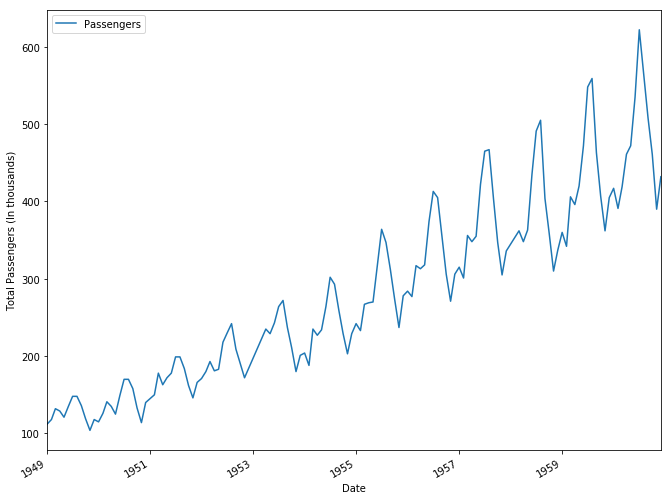

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit


# Load the data in pandas
airline_data = pd.read_csv('international-airline-passengers.csv', index_col='Date', parse_dates=['Date'])

'''
Data is loaded with proper datetime format, and next step I would like do basic plot of this data to get the general idea of the 
structure of data
'''
airline_data.plot(figsize = (11, 9))
plt.ylabel('Total Passengers (In thousands)')
plt.xlabel('Date')
plt.show()

In [5]:
'''
From this above simple graph, we can a see a increasing trend of data but also sudden rise in some months. It seems those are 
some seasonality of this timeseries data. Lets find out those and plot it.


Plotting of trend and seasonality data might not go exactly as it supposed to be because for some year, I have some missing 
months. But the plot below should give overall broad picture about the seasonality and trend in this data
'''
rcParams['figure.figsize'] = 13,11

time_division = sm.tsa.seasonal_decompose(airline_data[['Passengers']], freq= 11)

trend_inData = time_division.trend
trend_inData.columns = ['trend']

seasonal_inData = time_division.seasonal
seasonal_inData.columns = ['seasonal']

# lets merge and make a one dataframe which will make it easier for the futher manupulation

airline_data_Processed = pd.concat([airline_data, trend_inData, seasonal_inData], axis= 1)

# lets print first five rows

print(airline_data_Processed.head())

            Passengers  trend   seasonal
Date                                    
1949-01-01         112    NaN -18.595605
1949-02-01         118    NaN -33.380729
1949-03-01         132    NaN -36.422051
1949-04-01         129    NaN -18.744365
1949-05-01         121    NaN -13.364200


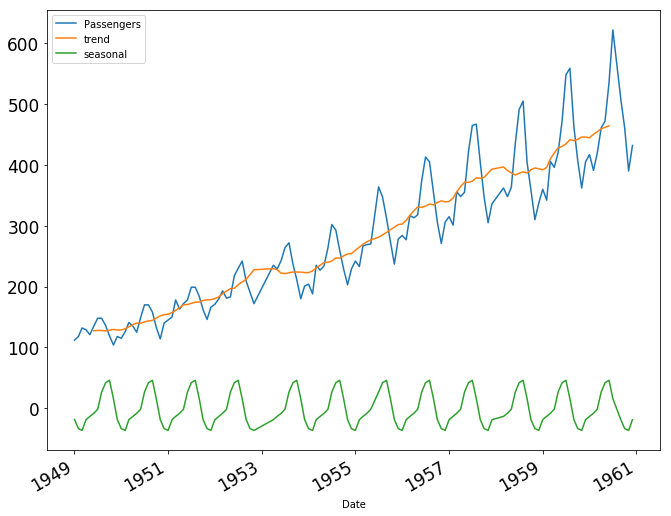

In [4]:
'''
Now, our data also contains trend and seasonal information. Lets plot to see this in detail to see the patterns of trend and
season. 
'''
axes = airline_data_Processed.plot(figsize = (11, 9), fontsize = 17)

axes.set_xlabel('Date')
plt.legend()
plt.show()


In [6]:
'''
It possible we might see some odd figure for some year because of missing data. But we can see in above graph that for the
middle of year ( probably July, August) there is sudden rise for each year.

Also, we there is trend of increasing order. 

This data has two main columns, date and passengers_values. For the simplicty purpose, I would like 
to separate date into (year and month) plus I want to do  some extra feature engineering using PolynomialFeatures for the better
prediction.
'''

# extract year and month from date. But before that lets remove date from index just for easier purposes

airline_data.reset_index(inplace= True)

airline_data['Year'] = airline_data['Date'].dt.year
airline_data['Month'] = airline_data['Date'].dt.month

airline_data.drop(['Date'], axis= 1, inplace= True)

X = airline_data.drop('Passengers', 1).values

y = airline_data['Passengers'].values

'''
I am not going to use train_test_split because this is timeseries data and random shuffling of timeseries is not good idea. 
Rather, I want to use Timeseriessplit method to divide the data into train and test and check the score and do prediction.
'''

ts = TimeSeriesSplit(n_splits= 4)

for tr_index, ts_index in ts.split(X):
    X_train, X_test  = X[tr_index], X[ts_index]
    y_train, y_test = y[tr_index], y[ts_index]
    

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(len(X_train) + len(X_test))
print(len(y_train) + len(y_test))

(109, 2)
(109,)
(27, 2)
(27,)
136
136


In [7]:
'''
I am going to use PolynomialFeatures with LinearRegression for the prediction model. I have tested with couple of other 
regression model too, but LinearRegression with PolynomialFeatures resulted on better score than other
'''
model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X_train, y_train)
score = (r2_score(y_test, model.predict(X_test)))

print(score)

0.838899971381655


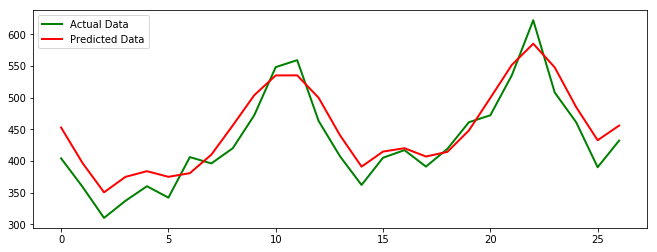

In [8]:
'''
Our R2_score result doesnt seems that bad. But before I am making any decision for this mode,  I would also want to plot between  
predicted values and testing values to see the difference between them and see if its follows some patterns there or not
'''

# Lets try to visualize this if it follows proper trends and seasonality of data

predictions = model.predict(X_test)

fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(y_test, color='g', lw=2, label = 'Actual Data')
ax.plot(predictions, color='r', lw=2, label = 'Predicted Data')

plt.legend()
plt.show()


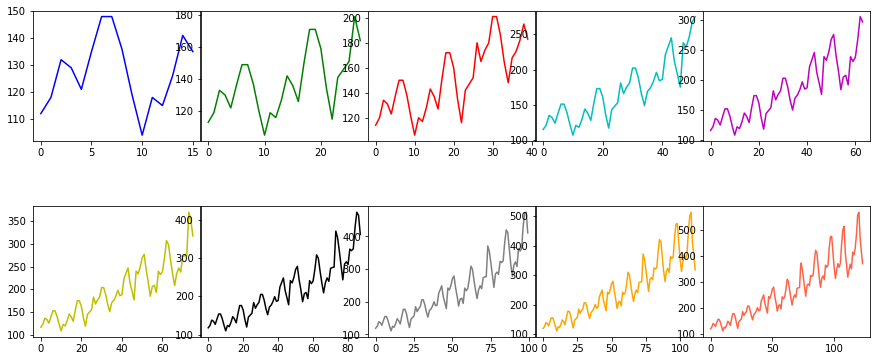

In [9]:
'''
Above graph shows that, our prediction model which was done in testing data is following the pattern. This is a good news but
before making any decision of the model performance results, I would like to do small time series cross validation check. 
The main point of this cross validation is to check how the prediction are being made. 

'''
cv = TimeSeriesSplit(n_splits= 10) # splitting data into 10 parts
fig, ax = plt.subplots(2,5, figsize=(15, 6))

fig.subplots_adjust(hspace = .5, wspace=.001)

ax = ax.ravel()

colors = ['b','g','r','c','m','y','k', 'grey', 'orange', 'tomato']

for i, (train, test) in enumerate(cv.split(X)):
    ax[i].plot(train, i + y[train], color= colors[i])
    

'''
we can see the size of the training set grew each time when we used the time series cross-validation object. 
This way, we can see  that predicted values is always based on the time we have trained on and it is not just the some 
interpolation of random data. 
'''

plt.show()


In [10]:
# Final task would be to prediction of those missing values which I have removed in the beginning
missing_dates = [(1952,12),(1953, 1), (1953, 2), (1953, 3), (1955, 6), (1960, 8), (1958, 1), (1958, 2)]

for i in (model.predict(missing_dates)): 
    print(int(i)) # (I cast to int because these were supposed to be passenger numbers)


181
184
203
201
324
585
347
343
